In [1]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Dict
from itertools import product
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import pickle
import pandas as pd
from scipy.stats import gaussian_kde
from os.path import join

C:\Users\alexk\anaconda3\envs\ESP\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Define functions

In [2]:
class Freq(object):
    """A class for calculating k-mer frequencies
    """

    def __init__(self):
        """Initialize class
        """
        # construct the different k-mer indexes
        self.aa = 'ACDEFGHIKLMNPQRSTVWY'
        self.idx_1 = {''.join(kmer): i for i, kmer in enumerate(list(self.aa))}
        self.idx_2 = {''.join(kmer): i for i, kmer in enumerate(list(product(self.aa, self.aa)))}
        self.idx_3 = {''.join(kmer): i for i, kmer in enumerate(list(product(self.aa, self.aa, self.aa)))}

    def count_one(self,
                  sequence: str,
                  k: int
                  ) -> (Dict, np.ndarray):
        """Obtain k-mer counts (1 <= k <= 3) of a single of protein sequence

        :param sequence: A single protein sequence
        :type sequence: list
        :param k: K-mer value to use
        :type k: int
        :return: A dict which is used to map k-mers to a position in the value array
        :rtype: [dict, np.ndarray)
        """
        # ensure that the sequence is ok
        assert 1 <= k <= 3, 'Error, k must be 1, 2, or 3'
        assert len(sequence) >= k, 'Error, the sequence is shorter than the specified k-mer size'
        sequence = sequence.upper()

        # make an index of all the k-mers
        if k == 1:
            idx = self.idx_1
        elif k == 2:
            idx = self.idx_2
            assert len(sequence) >= 2, 'Error, sequence must be longer than two amino acids'
        elif k == 3:
            idx = self.idx_3
            assert len(sequence) >= 3, 'Error, sequence must be longer than three amino acids'
        else:
            raise ValueError

        # go through and count
        count = np.zeros(len(self.aa)**k, dtype=np.uintc)  # counts from 0 to 4_294_967_295
        for i in range(0, (len(sequence) - k) + 1, 1):
            kmer = sequence[i:i + k]
            
            # guard against ambigous amino acids
            if idx.get(kmer) is None:
                continue
            
            count[idx[kmer]] = count[idx[kmer]] + 1

        return idx, count

    def freq_one(self,
                 sequence: str,
                 k: int
                 ) -> (Dict, np.ndarray):
        """Obtain k-mer frequencies (1 <= k <= 3) of a single of protein sequence

        :param sequence: A single protein sequence
        :type sequence: str
        :param k: K-mer value to use
        :type k: int
        :return: A dict which is used to map k-mers to a position in the value array
        :rtype: [dict, np.ndarray)
        """
        # assert 1 <= k <= 3, 'Error, k must be 1, 2, or 3'
        # assert_sequence(sequence)

        # get the count
        idx, count = self.count_one(sequence=sequence, k=k)

        # count to frequency
        frequency = count / count.sum()

        return idx, frequency

    def count_many(self,
                   sequences: list,
                   k: int
                   ) -> (Dict, np.ndarray):
        """Obtain k-mer counts (1 <= k <= 3) of a list of protein sequences

        :param sequences: A list of protein sequences
        :type sequences: list
        :param k: K-mer value to use
        :type k: int
        :return: A dict which is used to map k-mers to a position in the value array
        :rtype: [dict, np.ndarray)
        """
        assert isinstance(sequences, list), 'Error, the input must be a list of sequences'

        # go through and count all the sequences
        count_list = []
        for seq in sequences:
            idx, count = self.count_one(sequence=seq,
                                        k=k)
            count_list.append(count)

        # stack all the individual sequence counts together
        count = np.stack(count_list, axis=0)

        return idx, count

    def freq_many(self,
                  sequences: list,
                  k: int
                  ) -> (Dict, np.ndarray):
        """Obtain k-mer frequencies (1 <= k <= 3) of a list of protein sequences

        :param sequences: A list of protein sequences
        :type sequences: list
        :param k: K-mer value to use
        :type k: int
        :return: A dict which is used to map k-mers to a position in the value array
        :rtype: [dict, np.ndarray)
        """
        assert isinstance(sequences, list), 'Error, the input must be a list of sequences'

        # get the count
        idx, count = self.count_many(sequences=sequences,
                                     k=k)

        # count to frequency (within each sequence)
        frequency = count / np.sum(count, axis=1, keepdims=True)

        return idx, frequency


### Load data

In [7]:
# train set
with open(join("..", "data", "splits", 'df_train_all_positive.pkl'), 'rb') as f:
    data_train = pickle.load(f)
    
# test set
with open(join("..", "data", "splits", 'df_test_all_positive.pkl'), 'rb') as f:
    data_test = pickle.load(f)
    
# get unique sequences
train_sequences = set(data_train.Sequence)
test_sequences = set(data_test.Sequence)
seqs = list(train_sequences) + list(test_sequences)

# get unique embeddings
train_esm = np.unique(np.stack(data_train.ESM1b.values), axis=0)
test_esm = np.unique(np.stack(data_test.ESM1b.values), axis=0)
esm = np.concatenate([train_esm, test_esm], axis=0)

In [9]:
short_seqs = set([s for s in seqs if len(s) < 50])
short_seqs

{'ADKKIALVGAGNIGGTLAHLIGLKXLL',
 'AIGPVDEV',
 'APFSLATA',
 'AQAAPVPRPVXLSKKTDSF',
 'AQGRAALAQATE',
 'AVGDDTPQLY',
 'DKLWGGRFSGSTDPIMEMLNSSIACDQRLSEVDIQGSMAYAKALEKAGI',
 'GRAALAQATE',
 'MALKAVCVLKGAGETSGTVHFEQEDN',
 'MASSPSTTTNGACIWHPMPTGRATSSLGANDAKDRVPPAPPPLPRS',
 'MASSVGNVADSTGLAELAHREYQSGDFEAAERHCMQ',
 'MDAVPDTKGSSGPPRGTPETKLIIHRFSRSLPT',
 'MEGPSGYPSSAKTASFQ',
 'MEKNVGIHFAIKRENNVKKR',
 'MGEKLELRLKSPVGAEPAVYPWPLPVYDKHHDAAHEIIETIRGRALHSP',
 'MHMFSKPNKQFVLVDESNVEELIDEVEKHQT',
 'MIIGAVEAGGTKFVDGVGNEKGEIFER',
 'MKKHILLLFTYRGLVRKGKKSKRRK',
 'MKNLRNRSFLTLLDFSRQEVEFLLTLSEDL',
 'MLRCLDPWRRQLLSCSWSRLCPLKHSMFTMKLQ',
 'MLYANPNTESSPVGFRKKYDNFI',
 'MPLIVSLSIILHAKLTYTFEDAQLD',
 'MPLIVSSSIMIHAKLIYTFEDAQLD',
 'MRRVMKQSSCYFSKRTMILLLSLALMSLAFLKLPSFHTELK',
 'MSLHLLLFFFLQLFSSSLQQFPRVCSPRWAWECVG',
 'SDIDRTAIHEVMEQGRVTISKAGIHASLNARCSVL',
 'SGLLINQPKYSWLKELGL',
 'TELSGAPLDLYQYRGQVLLIPQFTGLLYQKSQQEGDVVDGLPSHQFHQY',
 'THEEHHEAKTL',
 'VVARNNFGTDRIFVTVTIKIPKKKEE'}

In [10]:
long_seqs = set([s for s in seqs if len(s) > 5000])
len(long_seqs)

8

In [11]:
set(data_test[data_test['Uniprot ID'].isin(data_train['Uniprot ID'])]['Uniprot ID'].values)

{'A0A1B0GWN9', 'B3A0L4', 'C0HJB2', 'P82858', 'Q7M3F7'}

In [12]:
data_train[data_train.Sequence == 'THEEHHEAKTL']

,Uniprot ID,molecule ID,Binding,ECFP,ESM1b,Sequence
5604,Q7M3F7,CHEBI:30616,1.0,0000000001000000000000000000000000000000000100...,"[0.036066197, 0.060103625, 0.016096095, 0.1314...",THEEHHEAKTL
7660,Q7M3F7,CHEBI:57634,1.0,0000000000000000000000000000000000001000000000...,"[0.036066197, 0.060103625, 0.016096095, 0.1314...",THEEHHEAKTL


In [13]:
data_test[data_test.Sequence == 'AIGPVDEV']

,Uniprot ID,molecule ID,Binding,ECFP,ESM1b,Sequence
3041,C0HJB2,CHEBI:17594,1,0000000000000000000000000000000000000000000000...,"[0.06878472, 0.01710924, 0.07067471, 0.2075113...",AIGPVDEV
12170,C0HJB2,CHEBI:18135,0,0000000000000000000000000000000000000000000000...,"[0.06878472, 0.01710924, 0.07067471, 0.2075113...",AIGPVDEV
12171,C0HJB2,C14519,0,0010000000000001000000000000000000000000000000...,"[0.06878472, 0.01710924, 0.07067471, 0.2075113...",AIGPVDEV


In [14]:
# filter
seqs = [s for s in seqs if s not in short_seqs]
seqs = [s for s in seqs if s not in long_seqs]

### Count frequencies

In [15]:
# instantiaite object
desc_obj = Freq()

# calculate monomer frequencies
_, freq_k1 = desc_obj.freq_many(sequences=seqs, 
                                k=1)

# calculate dimer frequencies
_, freq_k2 = desc_obj.freq_many(sequences=seqs, 
                                k=2)

# calculate trimer frequencies
_, freq_k3 = desc_obj.freq_many(sequences=seqs, 
                                k=3)

### Make PCA plots of codon frequencies

Processing freq k=1
Processing freq k=2
Processing freq k=3
Processing ESM-1b


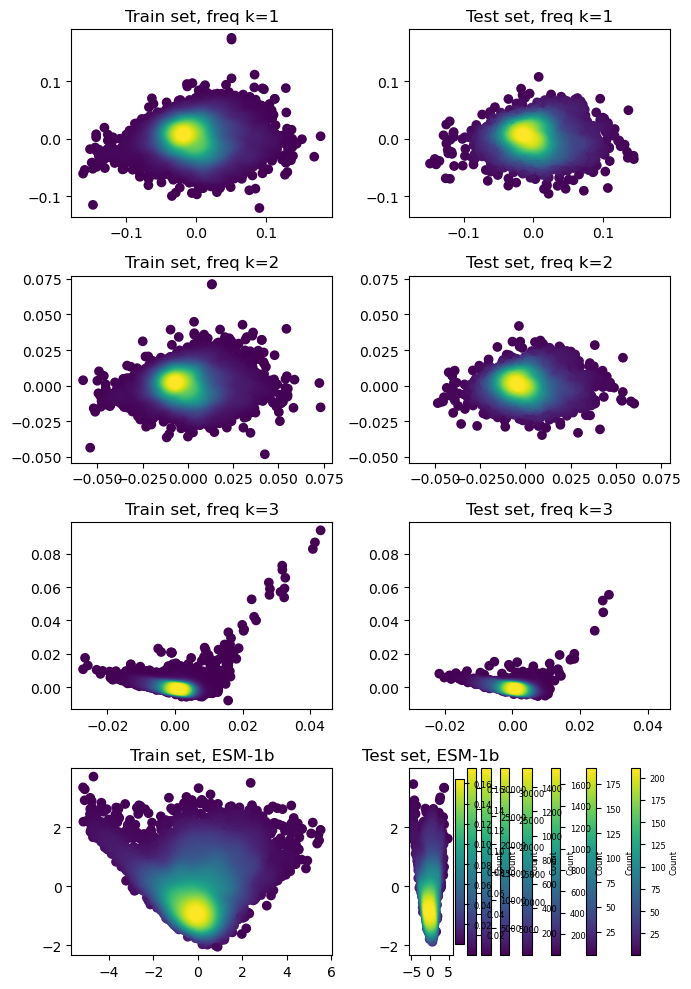

In [18]:
# parameters
axis_buffer = 0.05
cmap = 'viridis'

# plot
fig, axs = plt.subplots(4, 2, figsize=(7, 10))


# plot the k-mer frequencies
for i, (title, features) in enumerate(zip(['freq k=1', 'freq k=2', 'freq k=3', 'ESM-1b'], 
                                          [freq_k1, freq_k2, freq_k3, esm])):
    print(f"Processing {title}")
    
    mds = PCA(n_components=2)
    embedding = mds.fit_transform(features)

    min_val_x = min(embedding[:,0])
    max_val_x = max(embedding[:,0])
    val_range_x = max_val_x - min_val_x

    min_val_y = min(embedding[:,1])
    max_val_y = max(embedding[:,1])
    val_range_y = max_val_y - min_val_y

    # train set
    if title != 'ESM-1b':
        train_len = len(train_sequences)
    else:
        train_len = train_esm.shape[0]
        
    x = embedding[:train_len, 0]
    y = embedding[:train_len, 1]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    sort_mask = np.argsort(z)
        
    ax = axs[i, 0]
    sc = ax.scatter(x=x[sort_mask],
               y=y[sort_mask],
               c=z[sort_mask],
               cmap=cmap)

    ax.set_xlim([min_val_x - val_range_x * axis_buffer, 
                 max_val_x + val_range_x * axis_buffer])
    ax.set_ylim([min_val_y - val_range_y * axis_buffer, 
                 max_val_y + val_range_y * axis_buffer])

    ax.set_title(f'Train set, {title}')
    
    cb = fig.colorbar(sc, orientation="vertical")
    cb.ax.tick_params(labelsize=6) 
    cb.set_label('Count', 
                 rotation=90, 
                 labelpad=3, 
                 fontsize=6)

    # test set
    x = embedding[train_len:, 0]
    y = embedding[train_len:, 1]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    sort_mask = np.argsort(z)
    
    ax = axs[i, 1]
    sc = ax.scatter(x=x[sort_mask],
               y=y[sort_mask],
               c=z[sort_mask],
               cmap=cmap)

    ax.set_xlim([min_val_x - val_range_x * axis_buffer, 
                 max_val_x + val_range_x * axis_buffer])
    ax.set_ylim([min_val_y - val_range_y * axis_buffer, 
                 max_val_y + val_range_y * axis_buffer])

    ax.set_title(f'Test set, {title}')

    cb = fig.colorbar(sc, orientation="vertical")
    cb.ax.tick_params(labelsize=6) 
    cb.set_label('Count', 
                 rotation=90, 
                 labelpad=3, 
                 fontsize=6)
        
plt.tight_layout()


fig.savefig('train_test_set_plot_PCA.png', 
            dpi=300, 
            pad_inches=0.1)

### Make MDS plots from codon frequencies

In [ ]:
# parameters
axis_buffer = 0.05
cmap = 'viridis'

# plot
fig, axs = plt.subplots(4, 2, figsize=(6, 10))


# plot the k-mer frequencies
for i, (title, features) in enumerate(zip(['freq k=1', 'freq k=2', 'freq k=3', 'ESM-1b'], 
                                          [freq_k1, freq_k2, freq_k3, esm])):
    print(f"Processing {title}")
    
    mds = MDS(n_components=2)
    embedding = mds.fit_transform(features)

    min_val_x = min(embedding[:,0])
    max_val_x = max(embedding[:,0])
    val_range_x = max_val_x - min_val_x

    min_val_y = min(embedding[:,1])
    max_val_y = max(embedding[:,1])
    val_range_y = max_val_y - min_val_y

    # train set
    if title != 'ESM-1b':
        train_len = len(train_sequences)
    else:
        train_len = train_esm.shape[0]
        
    x = embedding[:train_len, 0]
    y = embedding[:train_len, 1]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    sort_mask = np.argsort(z)
        
    ax = axs[i, 0]
    sc = ax.scatter(x=x[sort_mask],
               y=y[sort_mask],
               c=z[sort_mask],
               cmap=cmap)

    ax.set_xlim([min_val_x - val_range_x * axis_buffer, 
                 max_val_x + val_range_x * axis_buffer])
    ax.set_ylim([min_val_y - val_range_y * axis_buffer, 
                 max_val_y + val_range_y * axis_buffer])

    ax.set_title(f'Train set, {title}')
    
    cb = fig.colorbar(sc, orientation="vertical")
    cb.ax.tick_params(labelsize=6) 
    cb.set_label('Count', 
                 rotation=90, 
                 labelpad=3, 
                 fontsize=6)

    # test set
    x = embedding[train_len:, 0]
    y = embedding[train_len:, 1]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    sort_mask = np.argsort(z)
    
    ax = axs[i, 1]
    sc = ax.scatter(x=x[sort_mask],
               y=y[sort_mask],
               c=z[sort_mask],
               cmap=cmap)

    ax.set_xlim([min_val_x - val_range_x * axis_buffer, 
                 max_val_x + val_range_x * axis_buffer])
    ax.set_ylim([min_val_y - val_range_y * axis_buffer, 
                 max_val_y + val_range_y * axis_buffer])

    ax.set_title(f'Test set, {title}')

    cb = fig.colorbar(sc, orientation="vertical")
    cb.ax.tick_params(labelsize=6) 
    cb.set_label('Count', 
                 rotation=90, 
                 labelpad=3, 
                 fontsize=6)
        
plt.tight_layout()


fig.savefig('train_test_set_plot_MDS.svg', 
            dpi=300, 
            pad_inches=0.1)

Processing freq k=1
